<a href="https://colab.research.google.com/github/netkachevhum/master_hw/blob/main/netkachev_db_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pymorphy2
!pip install pymystem3

     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 8.2 MB 20.3 MB/s 


In [3]:
from google.colab import files
import sqlite3
import pandas as pd


from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

import warnings
warnings.filterwarnings('ignore')

morph = MorphAnalyzer()
m = Mystem()
moprh = MorphAnalyzer()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
random.seed = 23

In [ ]:
def cleanse(text):
    exclude = ",{}*%<>@—:;\"\'()[]+=^~#…&—`123456789-«»0!?.\xa0\t"
    no_orpho = [symb for symb in text if not symb in exclude]
    return "".join(no_orpho) #возвращает почищенный массив строк

def lemmatize(fl):
    # текст делится на леммы
    src = ""
    with open(fl, "r+", encoding="utf-8") as f:
        src = cleanse(f.read().lower())
    lemmas = [lemma for lemma in m.lemmatize(src) if not lemma in [" ", "\n","\ufeff"]]
    lemmas_unique = []
    for lemma in lemmas:
        if not lemma in lemmas_unique:
            lemmas_unique.append(lemma)
    print(lemmas_unique)
    return lemmas_unique

#считаем леммы разных слов и разных частей речи
def know_cat(lemmas):
    lemmas_with_cats = [(lemma, morph.parse(lemma)[0].tag.POS) for lemma in lemmas if not lemma == "  "] # массив с парами -- слово/часть речи
    return lemmas_with_cats


Я делаю базу данных, состоящую из четырех таблиц.
Это исследование про распределение частей речи (и связанных вещей) у Пастернака и Набокова (на материале малой прозы). Есть две таблицы с леммами -- у каждой из которых указывается часть речи. Также есть две таблицы с именами -- и для каждого имени указывается его длина в символах. 

Данные об именах -- подсегменте основной таблицы -- удобно гранить отдельно. Этим в данном случае оправдано использование баз данных.

Это позволяет смотреть, как, в целом, стиль влияет на синтаксис -- определяет ли стилистика частеречный набор, или нет. К тому же, можно мерить чисто визуальную "громоздкость" автора -- насколько длинную лексику он выбирает в определенной синтаксической области.

In [ ]:
def make_tables():
    text1 = ("Пастернак", "oxr.txt")
    text2 = ("Набоков", "nabokov_data.txt")
    table_words_1 = know_cat(lemmatize(text1[1]))
    table_words_2 = know_cat(lemmatize(text2[1]))
    # таблицы только с именами -- содержащие инфомрацию об их длине
    table_nouns_1 = [(word[0], len(word[0])) for word in table_words_1 if word[1] == 'NOUN']
    table_nouns_2 = [(word[0], len(word[0])) for word in table_words_2 if word[1] == 'NOUN']
    print(table_nouns_2)
    conn = sqlite3.connect('nabokov_pasternak.db')
    c = conn.cursor()
    c.execute("DROP TABLE IF EXISTS pasternak")
    c.execute("CREATE TABLE IF NOT EXISTS pasternak(lemma, category)")
    for row in table_words_1:
        c.execute("INSERT INTO pasternak VALUES (?, ?)", (row[0], row[1]))
    c.execute("DROP TABLE IF EXISTS nabokov")
    c.execute("CREATE TABLE IF NOT EXISTS nabokov(lemma, category)")
    for row in table_words_2:
        c.execute("INSERT INTO nabokov VALUES (?, ?)", (row[0], row[1]))
    c.execute("DROP TABLE IF EXISTS pasternak_nouns")
    c.execute("CREATE TABLE IF NOT EXISTS pasternak_nouns(lemma, length)")
    for row in table_nouns_1:
        c.execute("INSERT INTO pasternak_nouns VALUES (?, ?)", (row[0], row[1]))
    c.execute("DROP TABLE IF EXISTS nabokov_nouns")
    c.execute("CREATE TABLE IF NOT EXISTS nabokov_nouns(lemma, length)")
    for row in table_nouns_2:
        c.execute("INSERT INTO nabokov_nouns VALUES (?, ?)", (row[0], row[1]))
    conn.commit()
    conn.close()
make_tables()

считаем частотности разных категорий у двух авторов:

In [53]:
conn = sqlite3.connect('nabokov_pasternak.db')
cur = conn.cursor()


df1 = pd.read_sql_query("SELECT * FROM nabokov", con=conn)
pasternak_freqs = df1["category"].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
df2 = pd.read_sql_query("SELECT * FROM pasternak", con=conn)
nabokov_freqs = df2["category"].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')

df3 = pd.read_sql_query("SELECT * FROM pasternak_nouns", con=conn) #имена и их длина
df4 = pd.read_sql_query("SELECT * FROM nabokov_nouns", con=conn)
conn.close()

              lemma  length
0         пастернак       9
1             борис       5
2           грамота       7
3            память       6
4            райнер       6
...             ...     ...
3019    гражданство      11
3020      гражданин       9
3021        туземец       7
3022  независимость      13
3023          навык       5

[3024 rows x 2 columns]


посмотрим первые несколько вхождений в таблице с данными из Набокова:

In [ ]:
print(df2.head(10)["lemma"])

сделаем подмножество из каждого датафрейм -- возьмем только то, что имеет частотность больше 0.1

In [42]:
print(pasternak_freqs[pasternak_freqs["counts"] > 0.1])
print(nabokov_freqs[pasternak_freqs["counts"] > 0.1]) 

  unique_values    counts
0          NOUN  0.439168
1          INFN  0.246355
2          ADJF  0.217864
  unique_values    counts
0          NOUN  0.438579
1          INFN  0.262799
2          ADJF  0.186077


посмотрим, какие слова встречаются в обоих текстах

In [43]:

common_words = pd.merge(df1, df2, how='inner', on=['lemma'])
print(common_words)

             lemma category_x category_y
0         говорить       INFN       INFN
1         порусски       ADVB       ADVB
2            лавка       NOUN       NOUN
3                в       PREP       PREP
4              дом       NOUN       NOUN
...            ...        ...        ...
4958  безразличный       ADJF       ADJF
4959   угадываться       INFN       INFN
4960         объем       NOUN       NOUN
4961     неотлучно       ADVB       ADVB
4962       контакт       NOUN       NOUN

[4963 rows x 3 columns]


Визуализируем частотности по частям речи у Пастернака:

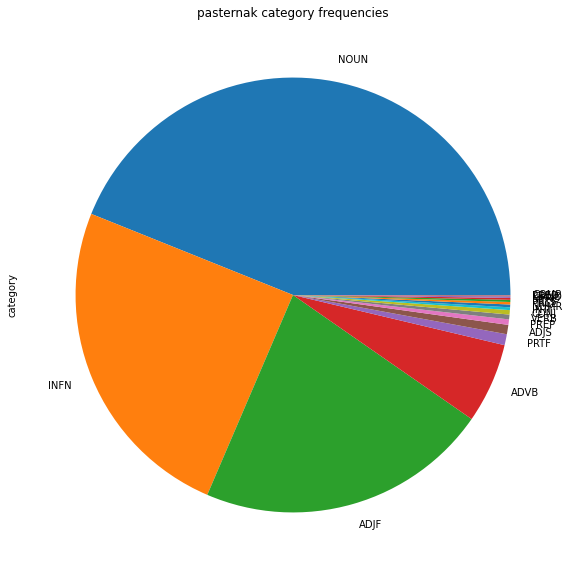

In [47]:
plt.figure(figsize=(10, 10))
df1['category'].value_counts().plot(kind='pie');
plt.title('pasternak category frequencies');

Теперь то же у Набокова:

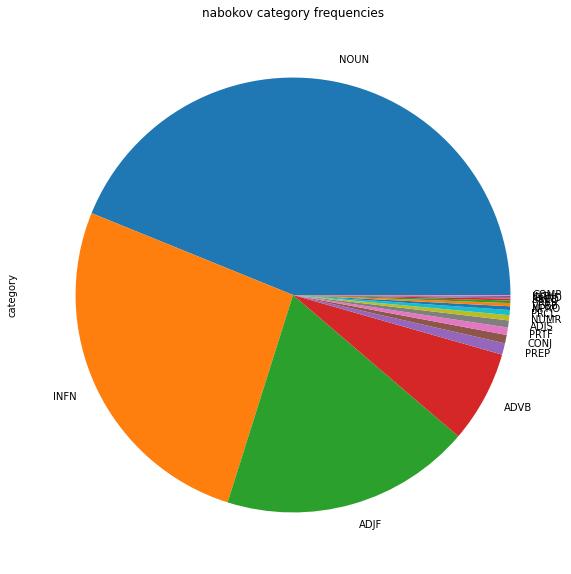

In [48]:
plt.figure(figsize=(10, 10))
df2['category'].value_counts().plot(kind='pie');
plt.title('nabokov category frequencies');

В целом видно, что части речи у двух авторов распределены одинкаово, что довольно любопытно. Видимо, сам язык в доволньо большой степени определяет частотность категорий, а стилистические факторы влияют, но не слишком драматично.

Теперь посмотрим, как распределена длина имен у каждого из двух авторов ("визуальная громоздкость"):

Text(0.5, 1.0, "length distribution in pasternak's texts")

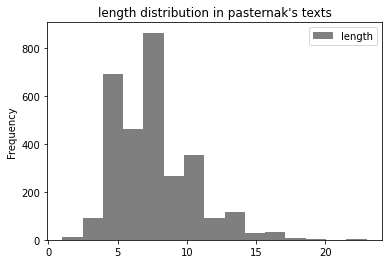

In [61]:
df3.plot.hist(bins=15, alpha=0.5,color='k', linestyle='dashed', linewidth=1)
plt.title("length distribution in pasternak's texts")

Text(0.5, 1.0, "length distribution in nabokov's texts")

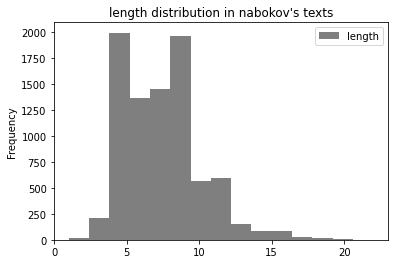

In [62]:
df4.plot.hist(bins=15, alpha=0.5,color='k', linestyle='dashed', linewidth=1)
plt.title("length distribution in nabokov's texts")

Как видно из графиков, распределение в целом похожее -- но Набоков, в целом, тяготеет к использованию более длинных имен.